# Final Augmentation training used again on the final model from GALICE.ipynb 

In [1]:
#23mar01.1

import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\01.1xleftyupCROP.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truth11.tif'  


img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

out_img_dir = 'dataset11/images/'
out_mask_dir = 'dataset11/masks/'

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
    
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0) 

      
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

      
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

     
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset11/images/', 'dataset11/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)



Data ready:
X: (35, 256, 256, 3)
Y: (35, 256, 256, 3)


In [4]:
from tensorflow.keras.models import load_model

model = load_model("unet_1_augmented_fine.h5", compile=False)

In [5]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [6]:
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

mask_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


seed = 42
image_generator = image_datagen.flow(X_train_split, batch_size=8, seed=seed)
mask_generator = mask_datagen.flow(Y_train_split, batch_size=8, seed=seed)
train_generator = zip(image_generator, mask_generator)

Epoch 1/30
2/2 [==============================] - 3s 2s/step - loss: 0.0749 - accuracy: 0.9713 - val_loss: 0.0660 - val_accuracy: 0.9731
Epoch 2/30
2/2 [==============================] - 3s 1s/step - loss: 0.0742 - accuracy: 0.9716 - val_loss: 0.0643 - val_accuracy: 0.9737
Epoch 3/30
2/2 [==============================] - 3s 2s/step - loss: 0.0756 - accuracy: 0.9712 - val_loss: 0.0651 - val_accuracy: 0.9735
Epoch 4/30
2/2 [==============================] - 3s 2s/step - loss: 0.0750 - accuracy: 0.9722 - val_loss: 0.0649 - val_accuracy: 0.9736
Epoch 5/30
2/2 [==============================] - 3s 1s/step - loss: 0.0765 - accuracy: 0.9711 - val_loss: 0.0634 - val_accuracy: 0.9743
Epoch 6/30
2/2 [==============================] - 3s 2s/step - loss: 0.0735 - accuracy: 0.9722 - val_loss: 0.0656 - val_accuracy: 0.9731
Epoch 7/30
2/2 [==============================] - 3s 2s/step - loss: 0.0779 - accuracy: 0.9711 - val_loss: 0.0635 - val_accuracy: 0.9742
Epoch 8/30
2/2 [=========================

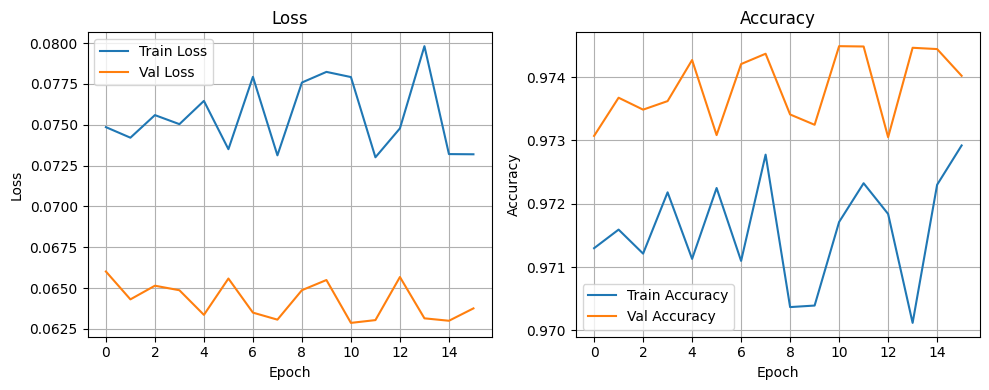

NameError: name 'pred_probs' is not defined

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train_split) // 8,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[
        ModelCheckpoint('unet_1_augmented_fine2.h5', save_best_only=True),
        EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
X_val


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

In [11]:
pred_probs = model.predict(X_val)


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 504ms/step


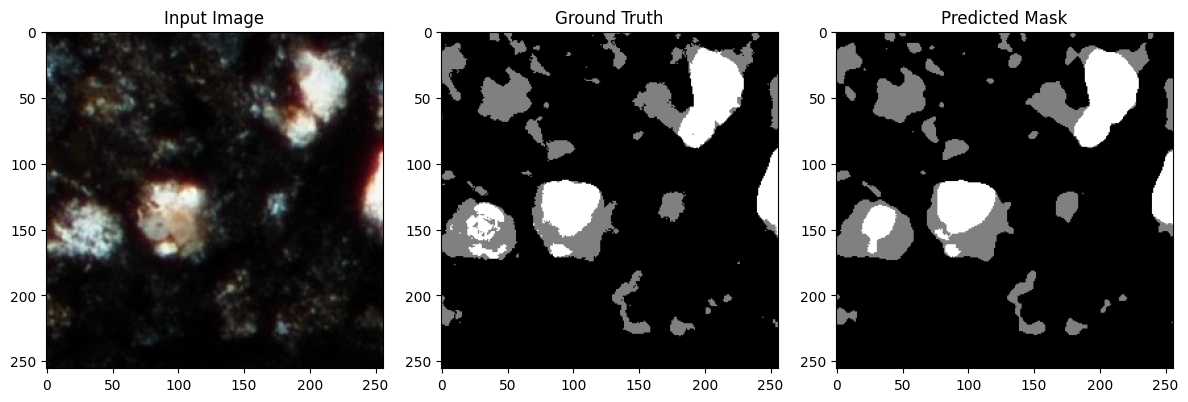

In [12]:
import matplotlib.pyplot as plt

i = 0  

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

In [19]:
num_train_images = len(X_train_split)
batch_size = 8
epochs = 30

steps_per_epoch = num_train_images // batch_size
total_augmented_images = steps_per_epoch * batch_size * epochs

print("Original training images:", num_train_images)
print("Total augmented images generated during training:", total_augmented_images)


Original training images: 22
Total augmented images generated during training: 480


In [1]:
#Applying augmented model to image 23mar18
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23mar01.8.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground_truth18.tif'  


out_img_dir = 'dataset18/images/'
out_mask_dir = 'dataset18/masks/'


img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
       
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0)  

      
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

      
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

        
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset18/images/', 'dataset18/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)



Data ready:
X: (12, 256, 256, 3)
Y: (12, 256, 256, 3)


In [2]:
#23mar18
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


IMG_SIZE = 256
NUM_CLASSES = 3

original_img_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\23GFNI5.1.jpg'
mask_path = r'C:\Users\Nurana\OneDrive - Texas Tech University\Proposal\Segmentation\input_images\ground51.tif'  


out_img_dir = 'dataset51/images/'
out_mask_dir = 'dataset51/masks/'



img = cv2.imread(original_img_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)


def load_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    X = []
    Y = []

    for img_name, mask_name in zip(image_files, mask_files):
        
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img / 255.0) 

       
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

       
        class_0 = (mask < 64)             # black → class 0
        class_1 = (mask >= 64) & (mask < 192)  # gray → class 1
        class_2 = (mask >= 192)           # white → class 2

        class_mask = np.zeros_like(mask, dtype=np.uint8)
        class_mask[class_1] = 1
        class_mask[class_2] = 2

        
        Y.append(to_categorical(class_mask, num_classes=NUM_CLASSES))

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.uint8)


X, Y = load_data('dataset51/images/', 'dataset51/masks/')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Data ready:")
print("X:", X.shape)
print("Y:", Y.shape)


Data ready:
X: (88, 256, 256, 3)
Y: (88, 256, 256, 3)


In [18]:
from tensorflow.keras.models import load_model

model = load_model("unet_1_augmented_fine2.h5", compile=False)

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
pred_probs = model.predict(X_val)


pred_classes = np.argmax(pred_probs, axis=-1)
true_classes = np.argmax(Y_val, axis=-1)

1/1 [==============================] - 1s 747ms/step


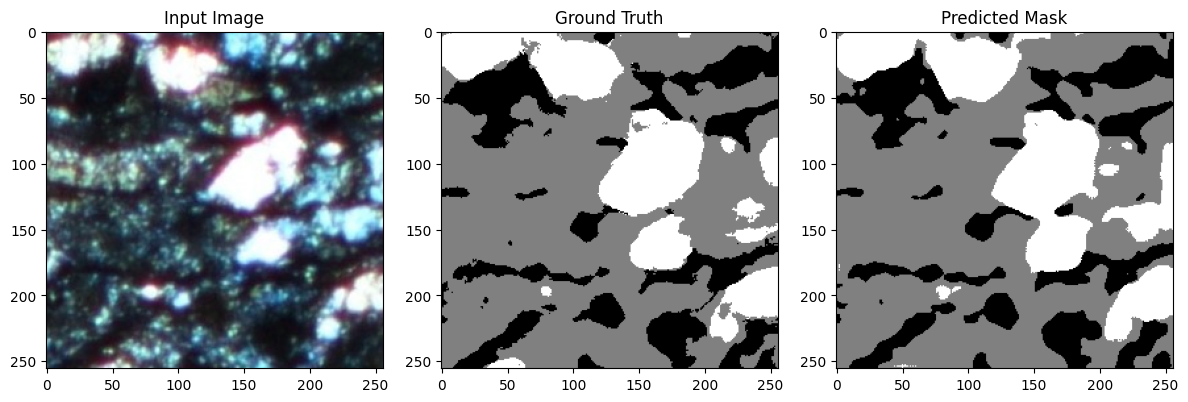

In [21]:
import matplotlib.pyplot as plt

i = 0  

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_val[i])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(true_classes[i], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_classes[i], cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

# With this file augmentation process ends and final model : unet_1_augmented_fine2.h5 is ready